In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd

print(tf.__version__)

2.16.1


In [3]:
data = pd.read_csv('colors.csv')
data.head(10)

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130
5,light urple,179,111,246
6,east side,172,145,206
7,florida seashells,250,228,199
8,paris,145,167,189
9,powder blush,247,215,215


In [4]:
len(data)
names = data["name"]

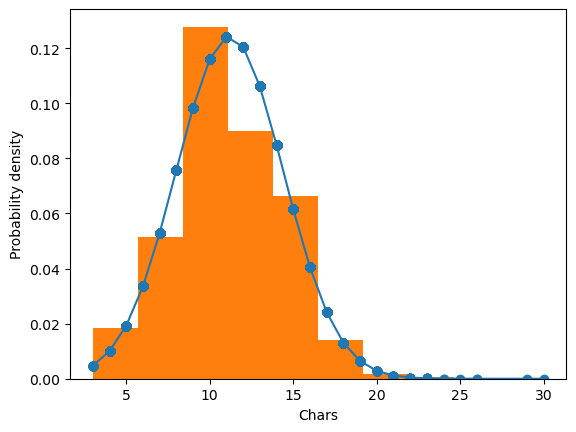

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

h = sorted(names.str.len().to_numpy())

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  # This is a fitting indeed
plt.plot(h, fit, '-o')
plt.hist(h, density=True)  # Use this to draw a histogram of your data
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

In [8]:
np.array(h).max()

30

In [9]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)

In [10]:
import tensorflow as tf
from tensorflow import keras

one_hot_names = tf.keras.utils.to_categorical(padded_names)
num_classes = one_hot_names.shape[-1]
print(num_classes)

28


In [11]:
one_hot_names.shape

(14157, 25, 28)

In [12]:
t.word_index

{'e': 1,
 'a': 2,
 'r': 3,
 ' ': 4,
 'i': 5,
 'n': 6,
 'l': 7,
 'o': 8,
 't': 9,
 's': 10,
 'c': 11,
 'u': 12,
 'd': 13,
 'g': 14,
 'p': 15,
 'h': 16,
 'm': 17,
 'b': 18,
 'y': 19,
 'w': 20,
 'k': 21,
 'f': 22,
 'v': 23,
 'z': 24,
 'q': 25,
 'j': 26,
 'x': 27}

In [13]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])


In [14]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_classes)))
model.add(Dropout(0.2))  # Add dropout to reduce overfitting
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

d:\Anaconda\envs\environmentjason\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
from tensorflow.keras.optimizers import RMSprop, SGD, Nadam, Adadelta, AdamW, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

lr_schedule = ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

learning_rate = 0.001
weight_decay = 0.004

optimizer = AdamW(weight_decay = weight_decay, learning_rate = learning_rate, use_ema=True)
# optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25, 256)        │       291,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,579 (4.12 MB)

 Trainable params: 1,080,579 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.load_weights('model_weights.h5')

In [18]:
history = model.fit(one_hot_names, normalized_values,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, lr_schedule])

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - acc: 0.7080 - loss: 0.0233 - val_acc: 0.7267 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - acc: 0.7055 - loss: 0.0229 - val_acc: 0.6956 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 3/50
398/399 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.7094 - loss: 0.0216
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
399/399 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - acc: 0.7094 - loss: 0.0216 - val_acc: 0.6992 - val_loss: 0.0413 - learning_rate: 0.0010
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - acc: 0.7186 - loss: 0.0191 - val_acc: 0.7069 - val_loss: 0.0394 - learning_rate: 1.0000e-04
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - acc: 0.7279 - loss: 0.0163 - val_acc: 0.7105 - val_loss: 0.0393 - learning_rate: 1.0000e-04
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - acc: 0.7289 - loss: 0.0159 - val_acc: 0.7126 - val_loss: 0.0389 - le

In [20]:
model.save('model.h5')

In [21]:
model.save('model.keras')

In [ ]:
history_ft = model.fit(one_hot_names, normalized_values,
                    epochs=25,
                    batch_size=32)

Epoch 1/25
443/443 [==============================] - 5s 11ms/step - loss: 0.0198 - acc: 0.7132
Epoch 2/25
443/443 [==============================] - 6s 14ms/step - loss: 0.0197 - acc: 0.7181
Epoch 3/25
443/443 [==============================] - 4s 10ms/step - loss: 0.0198 - acc: 0.7153
Epoch 4/25
443/443 [==============================] - 5s 11ms/step - loss: 0.0198 - acc: 0.7173
Epoch 5/25
443/443 [==============================] - 5s 11ms/step - loss: 0.0197 - acc: 0.7178
Epoch 6/25
443/443 [==============================] - 5s 11ms/step - loss: 0.0196 - acc: 0.7163
Epoch 7/25
443/443 [==============================] - 8s 17ms/step - loss: 0.0197 - acc: 0.7161
Epoch 8/25
443/443 [==============================] - 5s 10ms/step - loss: 0.0197 - acc: 0.7170
Epoch 9/25
443/443 [==============================] - 4s 9ms/step - loss: 0.0197 - acc: 0.7186
Epoch 10/25
443/443 [==============================] - 5s 11ms/step - loss: 0.0196 - acc: 0.7191
Epoch 11/25
443/443 [===================

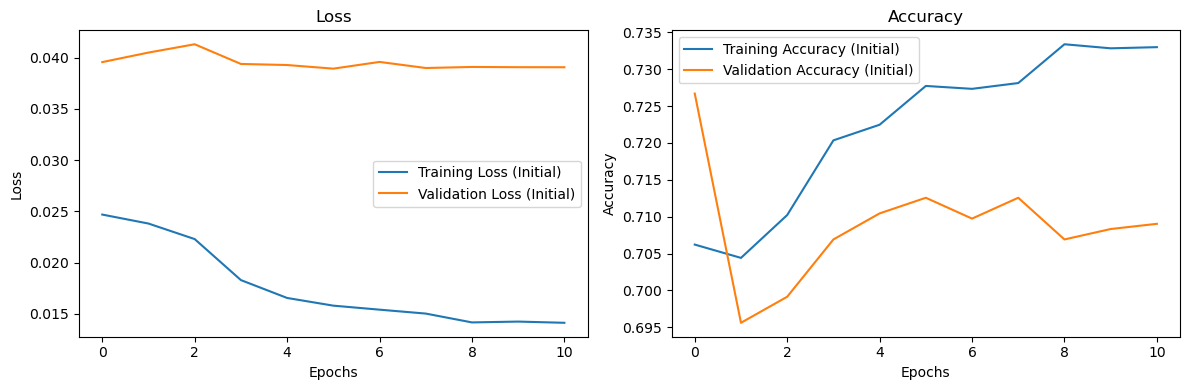

In [19]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for initial training and fine-tuning
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (Initial)')
plt.plot(history.history['val_loss'], label='Validation Loss (Initial)')
#plt.plot(history_fine_tune.history['loss'], label='Training Loss (Fine-tuning)')
#plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy (Initial)')
plt.plot(history.history['val_acc'], label='Validation Accuracy (Initial)')
#plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy (Fine-tuning)')
#plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

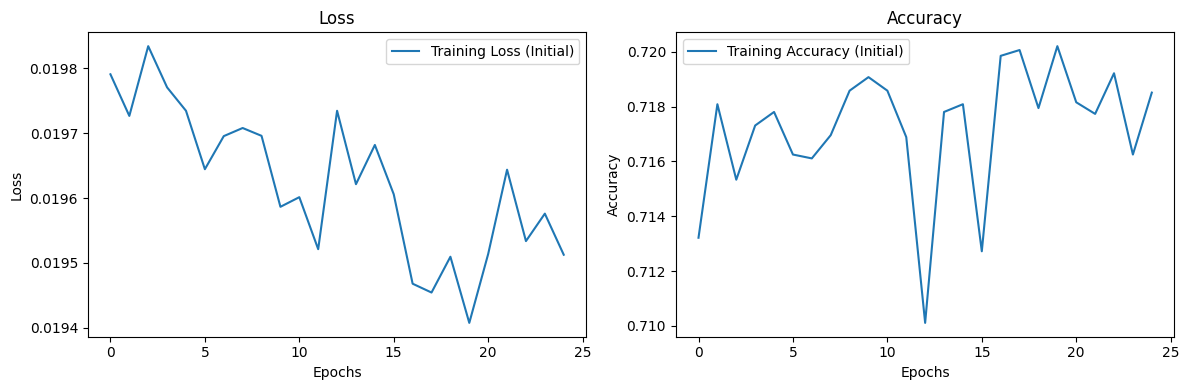

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for initial training and fine-tuning
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_ft.history['loss'], label='Training Loss (Initial)')
# plt.plot(history_ft.history['val_loss'], label='Validation Loss (Initial)')
#plt.plot(history_fine_tune.history['loss'], label='Training Loss (Fine-tuning)')
#plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_ft.history['acc'], label='Training Accuracy (Initial)')
# plt.plot(history_ft.history['val_acc'], label='Validation Accuracy (Initial)')
#plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy (Fine-tuning)')
#plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Color Training/model/model.h5')

In [ ]:
model.save("/content/drive/MyDrive/Color Training/model/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save_weights("/content/drive/MyDrive/Color Training/model/model_weights.h5")

In [22]:
import tensorflow as tf
from tensorflow import keras
import colorsys
import matplotlib.pyplot as plt
import numpy as np

# Plot color swatches
def plot_colors(colors, title=None):
    n = len(colors)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    fig.suptitle(title, fontsize=16)

    if n == 1:
        axes = [axes]  # Convert single Axes object to a list

    for i, color in enumerate(colors):
        data = np.ones((100, 100, 3)) * np.array(color) / 255
        axes[i].imshow(data, interpolation='nearest')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.show()

#Scales to 0-1
def scale(n):
    return int(n * 255)

# Get the complementary color
def get_complementary_color(rgb):
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)
    complementary_hue = (hsv[0] + 0.5) % 1
    complementary_rgb = tuple(round(c * 255) for c in colorsys.hsv_to_rgb(complementary_hue, hsv[1], hsv[2]))
    return complementary_rgb

# Get the Analogous color
def get_analogous_colors(rgb):
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)
    analogous_hues = [(hsv[0] + 0.083) % 1, (hsv[0] - 0.083) % 1]
    analogous_colors = [tuple(round(c * 255) for c in colorsys.hsv_to_rgb(hue, hsv[1], hsv[2])) for hue in analogous_hues]
    return analogous_colors

# Get the Triadic color
def get_triadic_colors(rgb):
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)
    triadic_hues = [(hsv[0] + 0.333) % 1, (hsv[0] + 0.667) % 1]
    triadic_colors = [tuple(round(c * 255) for c in colorsys.hsv_to_rgb(hue, hsv[1], hsv[2])) for hue in triadic_hues]
    return triadic_colors

# Get the Tetradic color
def get_tetradic_colors(rgb):
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)
    tetradic_hues = [(hsv[0] + 0.25) % 1, (hsv[0] + 0.5) % 1, (hsv[0] + 0.75) % 1]
    tetradic_colors = [tuple(round(c * 255) for c in colorsys.hsv_to_rgb(hue, hsv[1], hsv[2])) for hue in tetradic_hues]
    return tetradic_colors

# Get the Monochromatic color
def get_monochromatic_colors(rgb):
    hsv = colorsys.rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)
    monochromatic_colors = []
    for value in [0.8, 0.9, 1.0, 1.1, 1.2]:
        monochromatic_rgb = tuple(round(c * 255) for c in colorsys.hsv_to_rgb(hsv[0], hsv[1], min(max(value, 0), 1)))
        monochromatic_colors.append(monochromatic_rgb)
    return monochromatic_colors

#Generate color based on the input text and plot the colors
def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = tf.keras.utils.to_categorical(padded, num_classes=num_classes)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(f"{name}, R,G,B: {r}, {g}, {b}")

    # Get the complementary color
    complementary_color = get_complementary_color((r, g, b))
    analogous_colors = get_analogous_colors((r, g, b))
    triadic_colors = get_triadic_colors((r, g, b))
    tetradic_colors = get_tetradic_colors((r, g, b))
    monochromatic_colors = get_monochromatic_colors((r, g, b))

    # Print the color palette
    print("Color palette:")
    print(f"Original color: RGB={r, g, b}, Hex=#{('%02x%02x%02x' % (r, g, b))}")
    print(f"Complementary color: RGB={complementary_color}, Hex=#{('%02x%02x%02x' % complementary_color)}")
    print(f"Analogous colors: RGB={analogous_colors[0]}, Hex=#{('%02x%02x%02x' % analogous_colors[0])}, RGB={analogous_colors[1]}, Hex=#{('%02x%02x%02x' % analogous_colors[1])}")
    print(f"Triadic colors: RGB={triadic_colors[0]}, Hex=#{('%02x%02x%02x' % triadic_colors[0])}, RGB={triadic_colors[1]}, Hex=#{('%02x%02x%02x' % triadic_colors[1])}")
    print(f"Tetradic colors: RGB={tetradic_colors[0]}, Hex=#{('%02x%02x%02x' % tetradic_colors[0])}, RGB={tetradic_colors[1]}, Hex=#{('%02x%02x%02x' % tetradic_colors[1])}, RGB={tetradic_colors[2]}, Hex=#{('%02x%02x%02x' % tetradic_colors[2])}")
    print(f"Monochromatic colors: RGB={monochromatic_colors[0]}, Hex=#{('%02x%02x%02x' % monochromatic_colors[0])}, RGB={monochromatic_colors[1]}, Hex=#{('%02x%02x%02x' % monochromatic_colors[1])}, RGB={monochromatic_colors[2]}, Hex=#{('%02x%02x%02x' % monochromatic_colors[2])}, RGB={monochromatic_colors[3]}, Hex=#{('%02x%02x%02x' % monochromatic_colors[3])}, RGB={monochromatic_colors[4]}, Hex=#{('%02x%02x%02x' % monochromatic_colors[4])}")

    # Plot the color palettes separately
    plot_colors([(r, g, b)], title="Original Color")
    plot_colors([complementary_color], title="Complementary Color")
    plot_colors(analogous_colors, title="Analogous Colors")
    plot_colors(triadic_colors, title="Triadic Colors")
    plot_colors(tetradic_colors, title="Tetradic Colors")
    plot_colors(monochromatic_colors, title="Monochromatic Colors")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
blood red, R,G,B: 169, 37, 44
Color palette:
Original color: RGB=(169, 37, 44), Hex=#a9252c
Complementary color: RGB=(37, 169, 162), Hex=#25a9a2
Analogous colors: RGB=(169, 96, 37), Hex=#a96025, RGB=(169, 37, 110), Hex=#a9256e
Triadic colors: RGB=(44, 169, 37), Hex=#2ca925, RGB=(37, 44, 169), Hex=#252ca9
Tetradic colors: RGB=(110, 169, 37), Hex=#6ea925, RGB=(37, 169, 162), Hex=#25a9a2, RGB=(96, 37, 169), Hex=#6025a9
Monochromatic colors: RGB=(204, 45, 53), Hex=#cc2d35, RGB=(230, 50, 60), Hex=#e6323c, RGB=(255, 56, 66), Hex=#ff3842, RGB=(255, 56, 66), Hex=#ff3842, RGB=(255, 56, 66), Hex=#ff3842


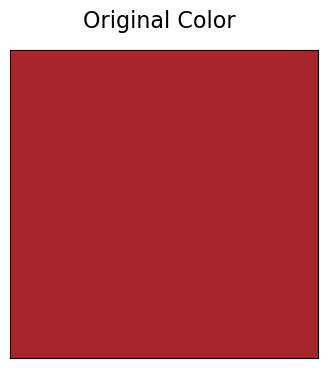

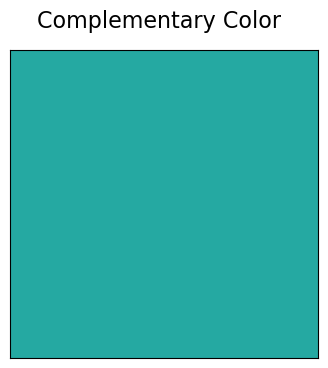

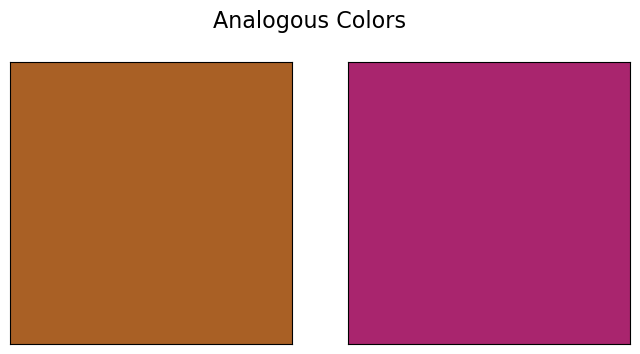

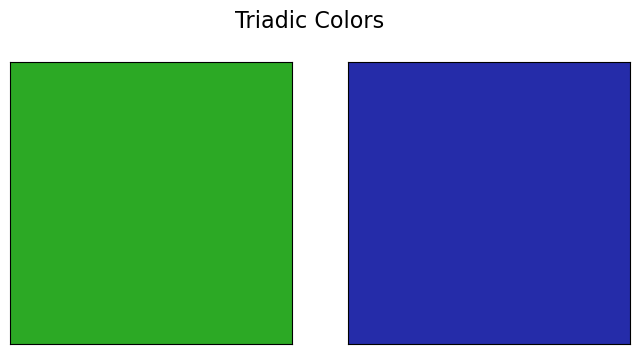

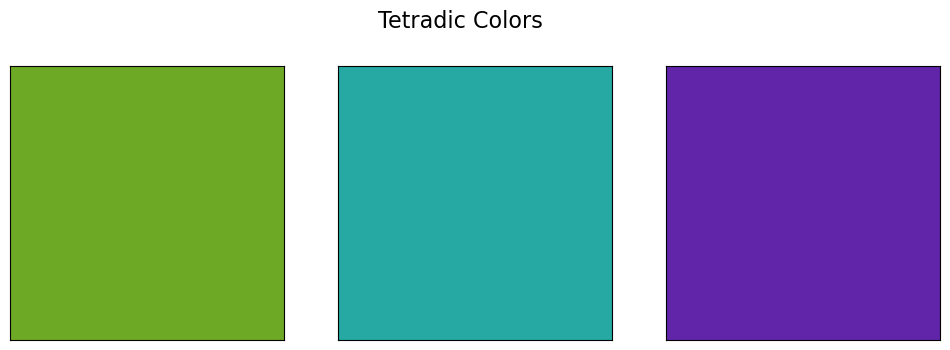

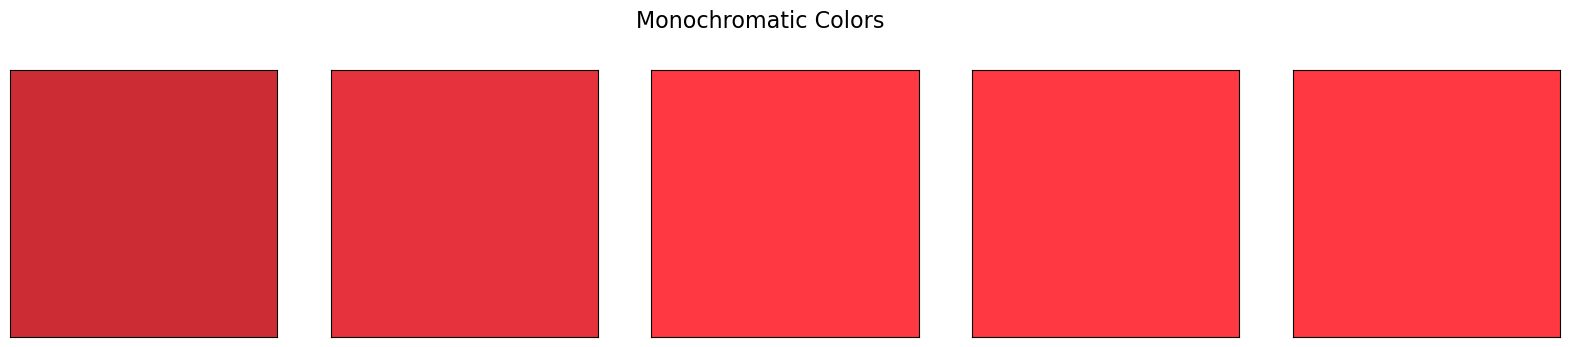

In [23]:
predict("blood red")

1/1 [==============================] - 0s 34ms/step
devil jin, R,G,B: 177, 144, 143
Color palette:
Original color: RGB=(177, 144, 143), Hex=#b1908f
Complementary color: RGB=(143, 176, 177), Hex=#8fb0b1
Analogous colors: RGB=(177, 161, 143), Hex=#b1a18f, RGB=(177, 143, 159), Hex=#b18f9f
Triadic colors: RGB=(143, 177, 144), Hex=#8fb190, RGB=(144, 143, 177), Hex=#908fb1
Tetradic colors: RGB=(159, 177, 143), Hex=#9fb18f, RGB=(143, 176, 177), Hex=#8fb0b1, RGB=(161, 143, 177), Hex=#a18fb1
Monochromatic colors: RGB=(204, 166, 165), Hex=#cca6a5, RGB=(230, 187, 185), Hex=#e6bbb9, RGB=(255, 207, 206), Hex=#ffcfce, RGB=(255, 207, 206), Hex=#ffcfce, RGB=(255, 207, 206), Hex=#ffcfce


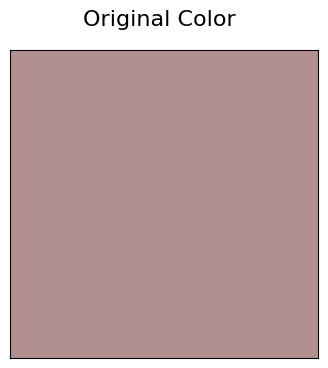

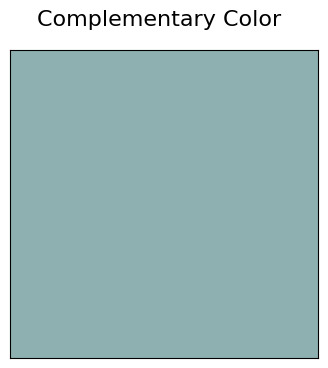

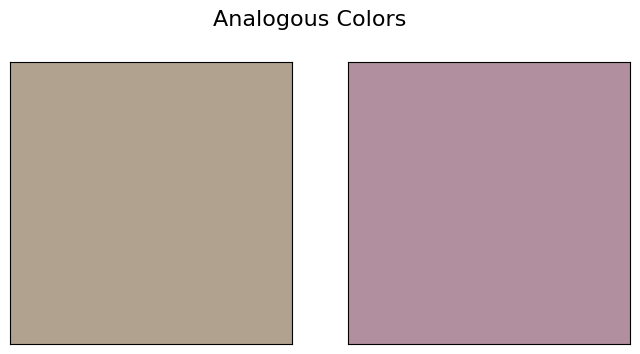

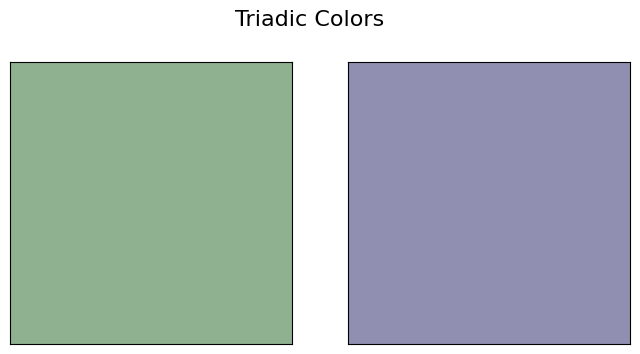

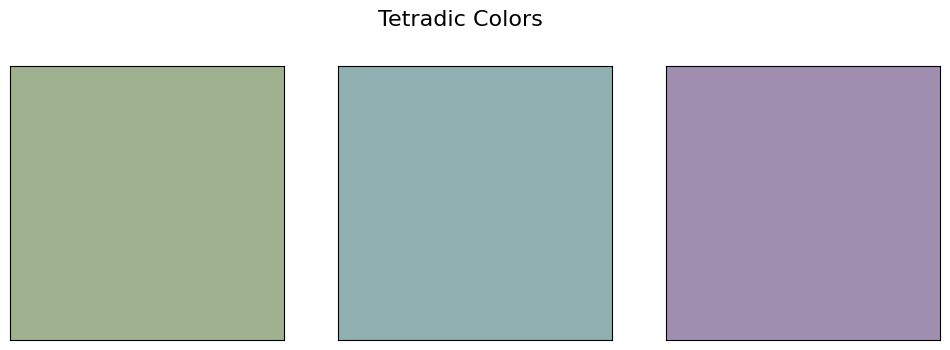

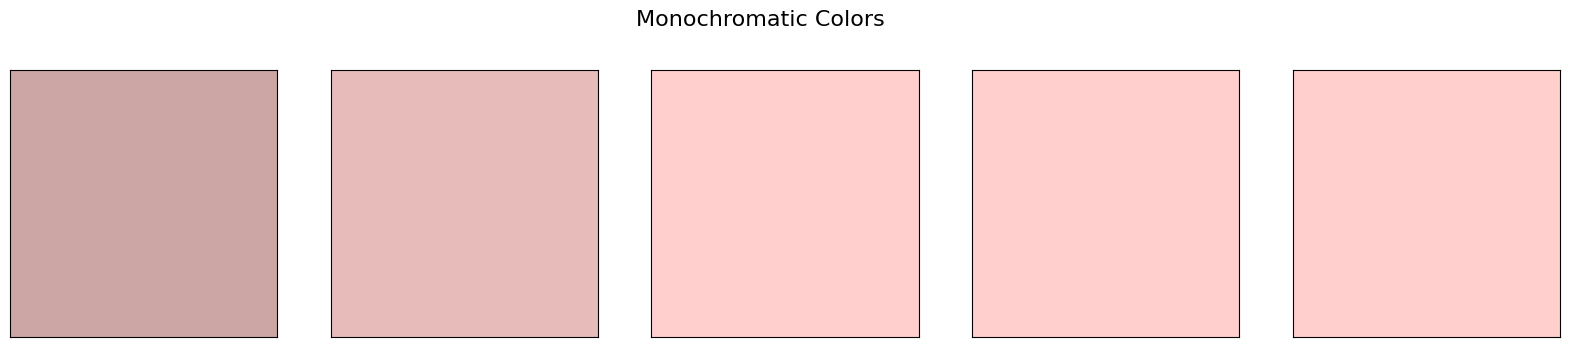

In [ ]:
predict("devil jin")